# Build Figures

Make all figures in this notebook to keep the results reproducible and the styling consistent.

Created: 4/11/2021

Author:  Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code-base':
    os.chdir('../')
sys.path.append('code-base')

import numpy as np
import pandas as pd
import glob, re, pprint, random
from datetime import datetime
import pprint

from scipy.stats import pearsonr, ttest_ind
from scipy.signal import savgol_filter
from scipy import interpolate

from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt

from src.formation import FormationCell
from src.utils import get_label_registry

import warnings
warnings.filterwarnings('ignore')

assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

## Configure plot settings

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


## Configure globals

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = np.array([0, 0, 0])
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = np.array([0, 0, 1])
COLOR_FAST_HT = np.array([1, 0, 0])
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = np.array([0, 0, 1])
COLOR_NEG = np.array([1, 0, 0])
COLOR_FULL_CELL = np.array([0, 0, 0])

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

## Load resources

In [5]:
cell_dict = dict()
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    cell_dict[cellid] = FormationCell(cellid)

# Figure 1: Concept Illustration

In [6]:
df_base_form = cell_dict[CELL_BASE].get_formation_data()
df_fast_form = cell_dict[CELL_FAST].get_formation_data()

df_base_form = df_base_form[df_base_form['Test Time (s)'] > 86400]
df_fast_form = df_fast_form[df_fast_form['Test Time (s)'] > 86400]

(-1.0, 65.0)

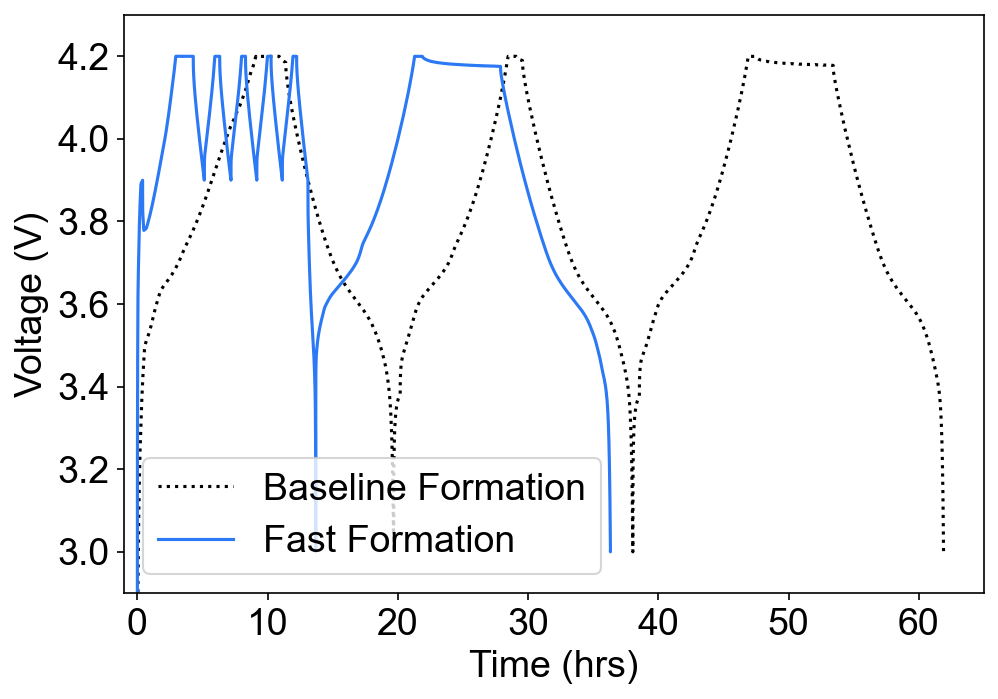

In [7]:
plt.figure()

plt.plot((df_base_form['Test Time (s)'] - 86400)/3600, df_base_form['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot((df_fast_form['Test Time (s)'] - 86400)/3600, df_fast_form['Potential (V)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)
plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
lgd = plt.legend(['Baseline Formation', 'Fast Formation'], frameon=True)
plt.ylim((2.9, 4.3))
plt.xlim((-1, 65))


In [8]:
df_base_rpt = cell_dict[CELL_BASE].get_aging_data_timeseries()
df_base_rpt = df_base_rpt[df_base_rpt['Cycle Number'] < 5]
df_base_rpt = df_base_rpt[df_base_rpt['Cycle Number'] > 1]

df_fast_rpt = cell_dict[CELL_FAST].get_aging_data_timeseries()
df_fast_rpt = df_fast_rpt[df_fast_rpt['Cycle Number'] < 5]
df_fast_rpt = df_fast_rpt[df_fast_rpt['Cycle Number'] > 1]

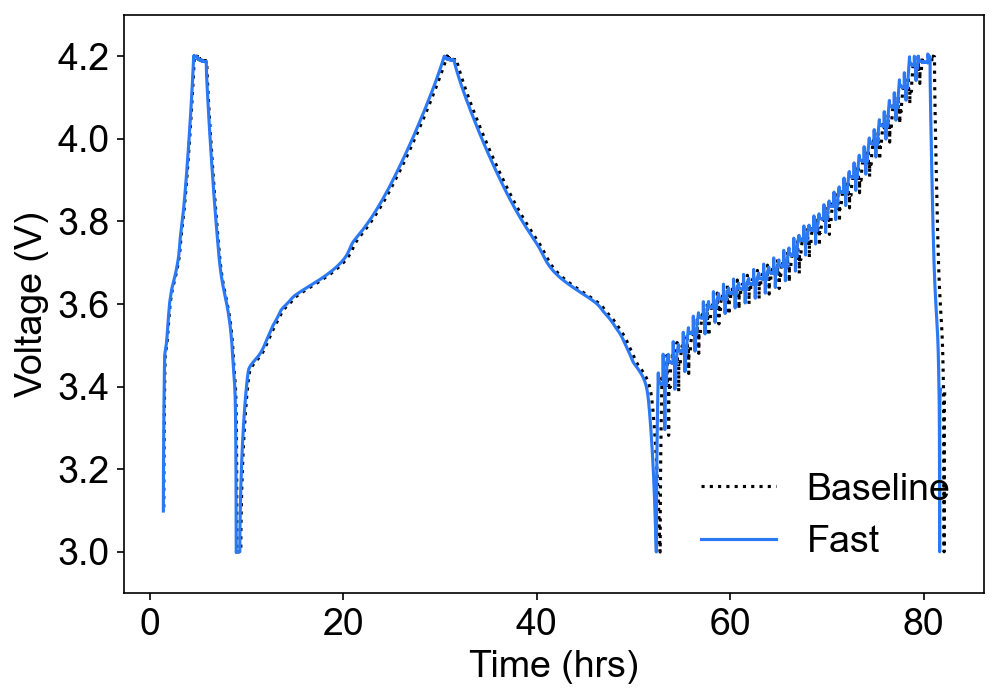

In [9]:
plt.subplot()

plt.plot(df_base_rpt['Test Time (s)'] / 3600, df_base_rpt['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(df_fast_rpt['Test Time (s)'] / 3600, df_fast_rpt['Potential (V)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)

plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
plt.ylim((2.9, 4.3))
plt.legend(['Baseline', 'Fast'], frameon=False)

In [10]:
df_base_cyc = cell_dict[CELL_BASE].get_aging_data_cycles()

idx = np.where((df_base_cyc['Total Charge Time (s)'] > 8500) |
               (df_base_cyc['Total Charge Time (s)'] < 100))[0]

df_base_cyc['Discharge Capacity (Ah)'][idx] = np.nan

In [11]:
df_fast_cyc = cell_dict[CELL_FAST].get_aging_data_cycles()

idx = np.where((df_fast_cyc['Total Charge Time (s)'] > 8500) |
               (df_fast_cyc['Total Charge Time (s)'] < 100))[0]

df_fast_cyc['Discharge Capacity (Ah)'][idx] = np.nan

(0.0, 500.0)

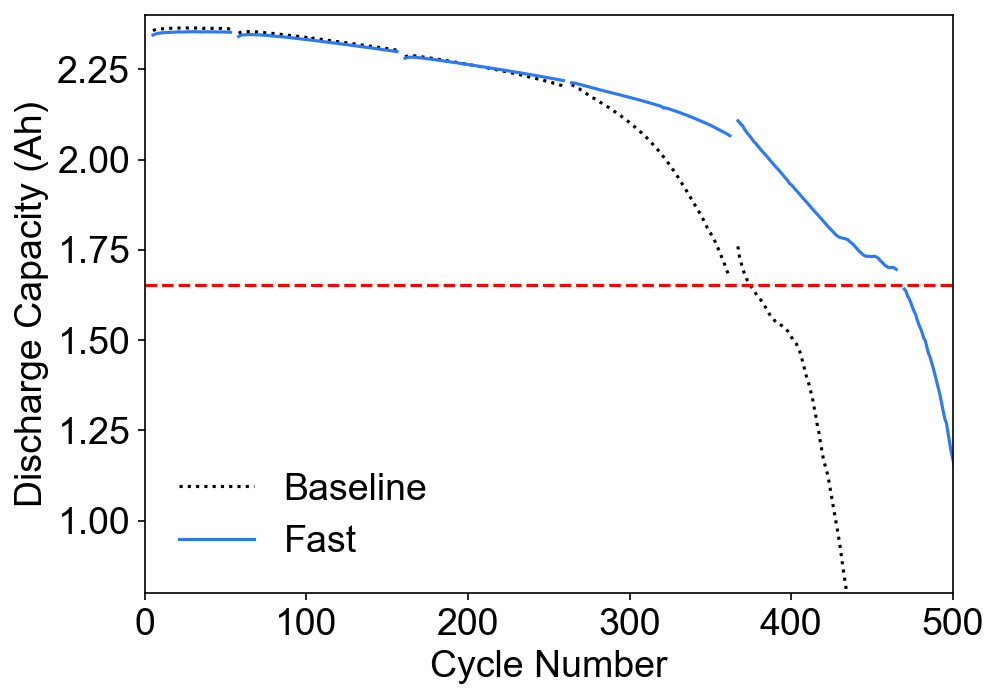

In [12]:
plt.figure()

plt.plot(df_base_cyc['Cycle Number'], df_base_cyc['Discharge Capacity (Ah)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(df_fast_cyc['Cycle Number'], df_fast_cyc['Discharge Capacity (Ah)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH , color='r', linestyle='--')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.legend(['Baseline', 'Fast'], frameon=False)
plt.ylim(CAPACITY_LIMITS_AH)
plt.xlim((0, 500))

(0.0, 6.7)

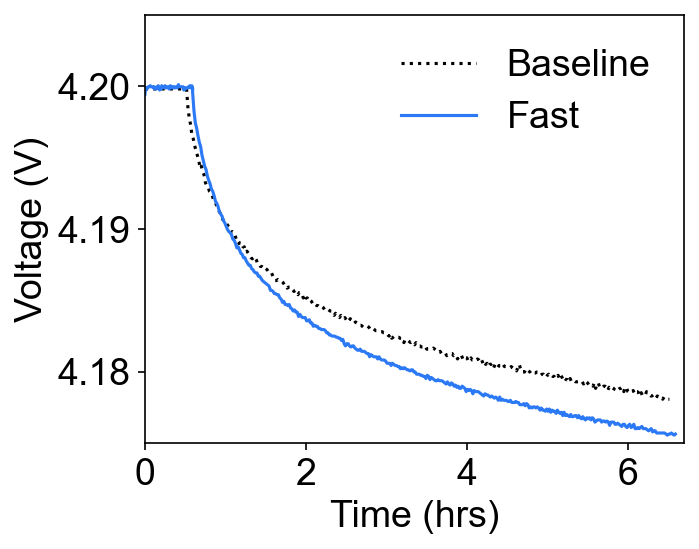

In [13]:
# Process voltage decay signal during 12-hour rest step
STEP_INDEX_6HR_REST = 12
CYCLE_INDEX_6HR_REST = 3
VOLTAGE_MAXIMUM = 4.2

df_base_deltav = df_base_form[(df_base_form['Cycle Number'] == 3) &
                              (
                                  (df_base_form['Step Index'] == 11) | 
                                  (df_base_form['Step Index'] == 12)
                              )]

df_base_deltav['Test Time (s)'] -= np.min(df_base_deltav['Test Time (s)'])

df_fast_deltav = df_fast_form[(df_fast_form['Cycle Number'] == 7) &
                              (
                                  (df_fast_form['Step Index'] == 13) | 
                                  (df_fast_form['Step Index'] == 12)
                              )]

df_fast_deltav['Test Time (s)'] -= np.min(df_fast_deltav['Test Time (s)'])

plt.figure(figsize=(5, 4))

plt.plot((df_base_deltav['Test Time (s)'])/3600, df_base_deltav['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot((df_fast_deltav['Test Time (s)'])/3600, df_fast_deltav['Potential (V)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)

plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
lgd = plt.legend(['Baseline', 'Fast'], frameon=False)
plt.ylim((4.175, 4.205))
plt.xlim((0, 6.7))

## Plot the DeltaV for all cells

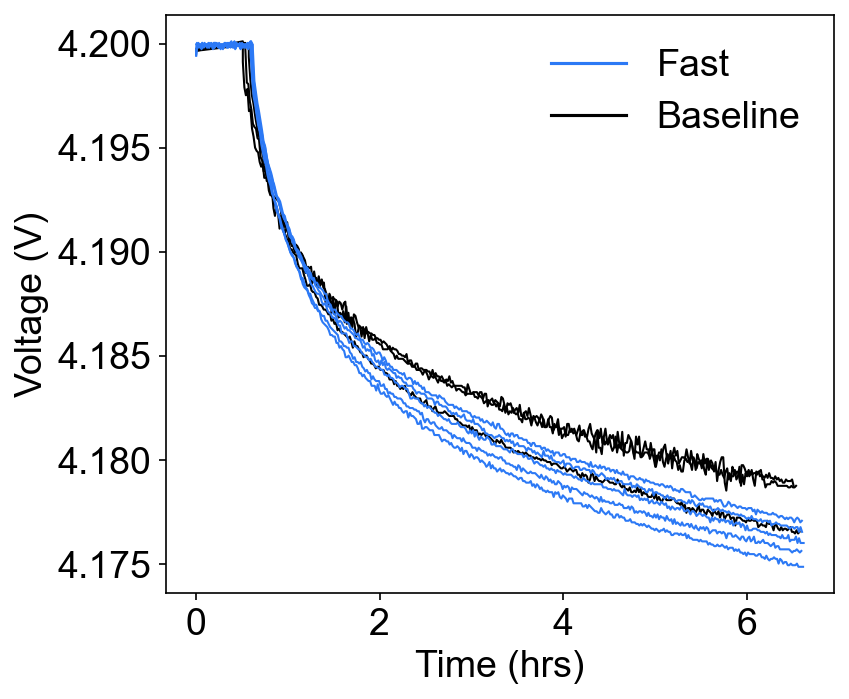

In [14]:
plt.figure(figsize=(6, 5))

plt.plot(np.nan, np.nan, label='Fast', color=COLOR_FAST)
plt.plot(np.nan, np.nan, label='Baseline', color=COLOR_BASE)

for cell in cell_dict.values():
        
    if cell.cellid == 9:
        continue
    
    if random.random() > 0.2:
        continue
        
    df_form = cell.get_formation_data()

    if cell.is_baseline_formation():
        color = COLOR_BASE
        linestyle = LINESTYLE_FAST
        
        df_deltav = df_form[(df_form['Cycle Number'] == 3) &
                              (
                                  (df_form['Step Index'] == 11) | 
                                  (df_form['Step Index'] == 12)
                              )]
        
#         df_deltav['Potential (V)'][df_deltav['Step Index'] == 12] = \
#         savgol_filter(df_deltav['Potential (V)'][df_deltav['Step Index'] == 12], 1, 3)

    else:
        color = COLOR_FAST
        linestyle = LINESTYLE_FAST
        
        df_deltav = df_form[(df_form['Cycle Number'] == 7) &
                              (
                                  (df_form['Step Index'] == 13) | 
                                  (df_form['Step Index'] == 12)
                              )]
            
#         df_deltav['Potential (V)'][df_deltav['Step Index'] == 13] = \
#         savgol_filter(df_deltav['Potential (V)'][df_deltav['Step Index'] == 13], 1, 3)

    df_deltav['Test Time (s)'] -= np.min(df_deltav['Test Time (s)'])

    plt.plot((df_deltav['Test Time (s)'])/3600, df_deltav['Potential (V)'], 
             color=color, 
             linestyle=linestyle, 
             linewidth=1,
             label='', 
             alpha=1)

plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')

lgd = plt.legend(frameon=False)

In [15]:
hppc_base_list = cell_dict[CELL_BASE].process_diagnostic_hppc_data()
# Unpack data from first available cycle
df_hppc_base = hppc_base_list[0]['data']

hppc_fast_list = cell_dict[CELL_FAST].process_diagnostic_hppc_data()
# Unpack data from first available cycle
df_hppc_fast = hppc_fast_list[0]['data']

df_hppc_fast_aged = hppc_fast_list[2]['data']

(-0.3, 3.0)

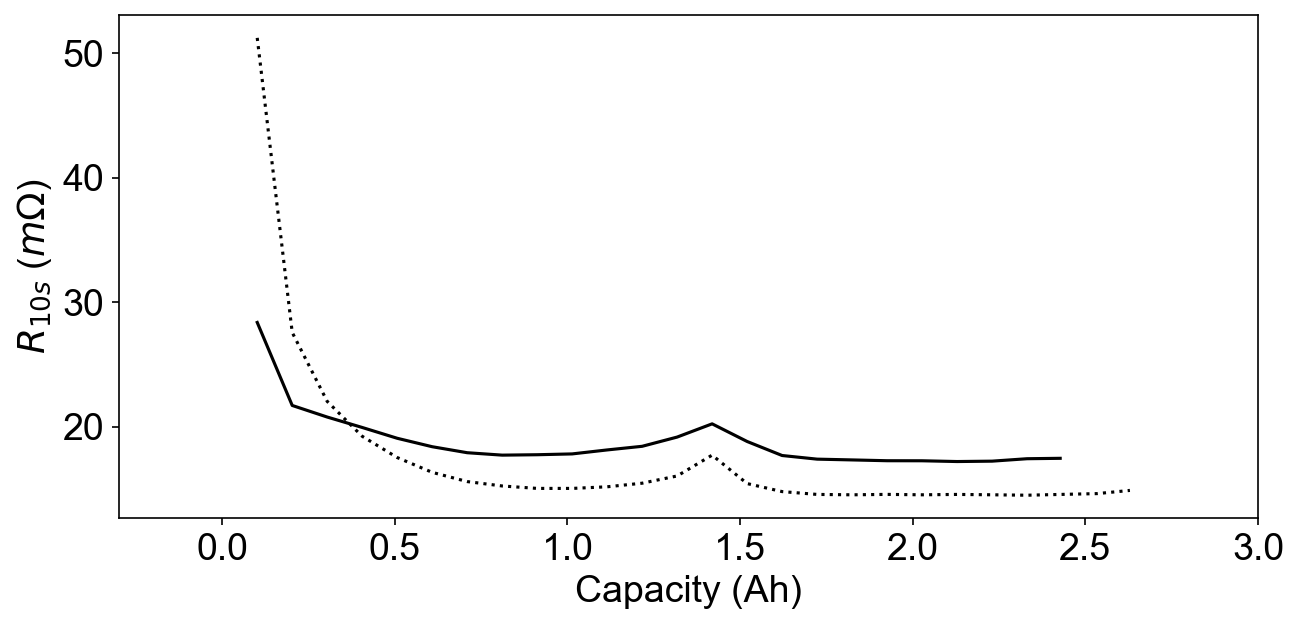

In [16]:
plt.figure(figsize=(9,4.5))

# plt.plot(df_hppc_base['capacity'],
#          df_hppc_base['resistance_10s_ohm']*1000, 
#          color=COLOR_BASE, linestyle=LINESTYLE_BASE)

plt.plot(df_hppc_fast['capacity'],
         df_hppc_fast['resistance_10s_ohm']*1000, 
         color='k', linestyle=':')

plt.plot(df_hppc_fast_aged['capacity'],
         df_hppc_fast_aged['resistance_10s_ohm']*1000, 
         color='k', linestyle=LINESTYLE_FAST)
         
plt.xlabel('Capacity (Ah)')
plt.ylabel('$R_{10s}$ ($m\Omega$)')
plt.xlim((-0.3, 3))
# lgd = plt.legend(['Baseline', 'Fast'], frameon=False)

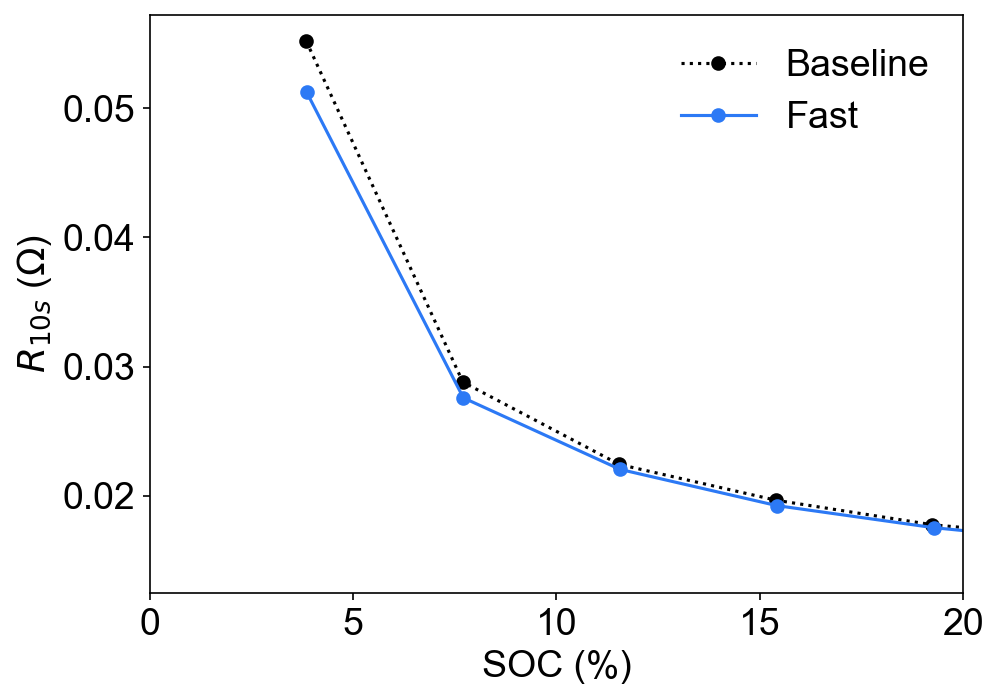

In [17]:
plt.figure()

plt.plot(df_hppc_base['capacity']/np.max(df_hppc_base['capacity'])*100,
         df_hppc_base['resistance_10s_ohm'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE, marker='o')

plt.plot(df_hppc_fast['capacity']/np.max(df_hppc_fast['capacity'])*100,
         df_hppc_fast['resistance_10s_ohm'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST, marker='o')
         
plt.xlabel('SOC (%)')
plt.ylabel('$R_{10s}$ ($\Omega$)')
plt.xlim((0, 20))
lgd = plt.legend(['Baseline', 'Fast'], frameon=False)

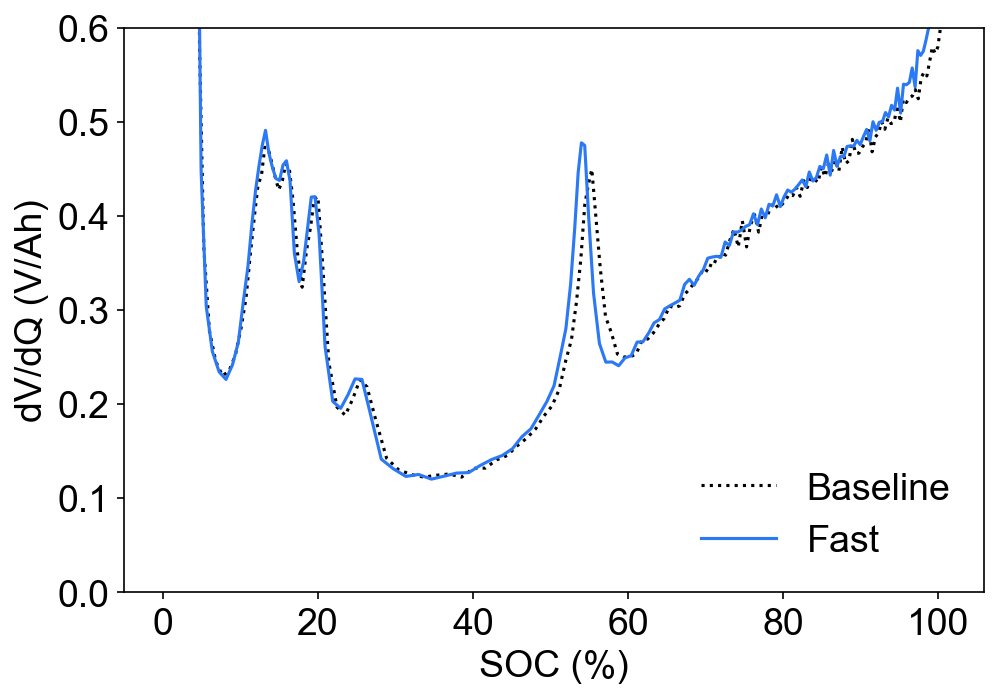

In [18]:
c20_base_list = cell_dict[CELL_BASE].process_diagnostic_c20_data()
c20_fast_list = cell_dict[CELL_FAST].process_diagnostic_c20_data()

df_c20_base = c20_base_list[0]
df_c20_fast = c20_fast_list[0]

plt.figure()
plt.plot(df_c20_base['chg_capacity']/np.max(df_c20_fast['chg_capacity'])*100, 
         df_c20_base['chg_dvdq'], linestyle=LINESTYLE_BASE, color=COLOR_BASE)

plt.plot(df_c20_fast['chg_capacity']/np.max(df_c20_fast['chg_capacity'])*100, 
         df_c20_fast['chg_dvdq'], linestyle=LINESTYLE_FAST, color=COLOR_FAST)

plt.ylim((0, 0.6))
plt.xlabel('SOC (%)')
plt.ylabel('dV/dQ (V/Ah)')
plt.legend(['Baseline', 'Fast'], frameon=False)

# Figure 2: Main Correlation Results

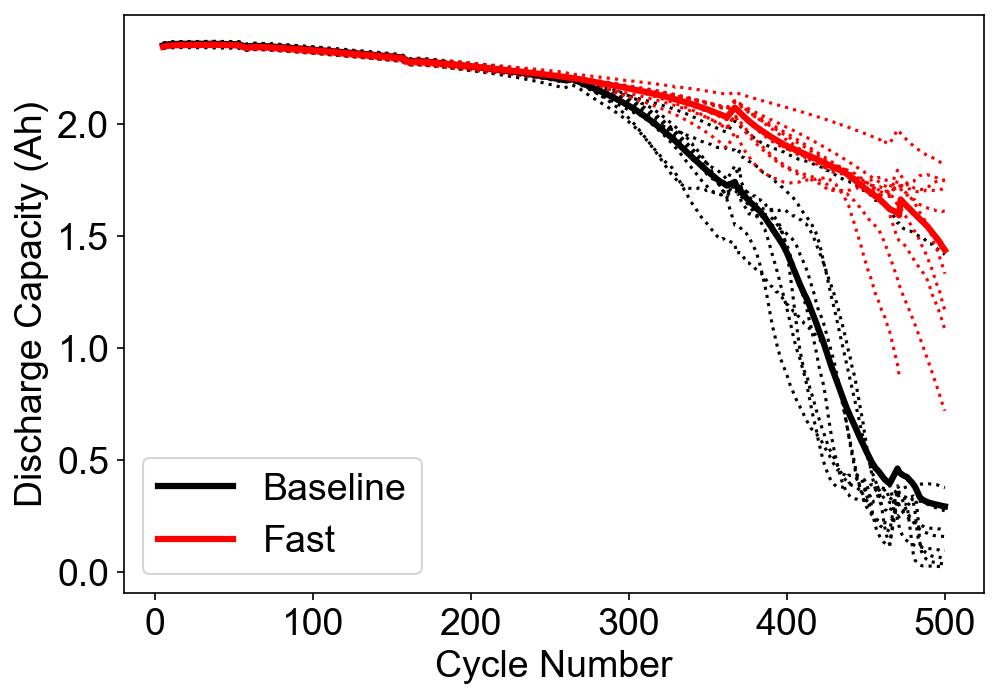

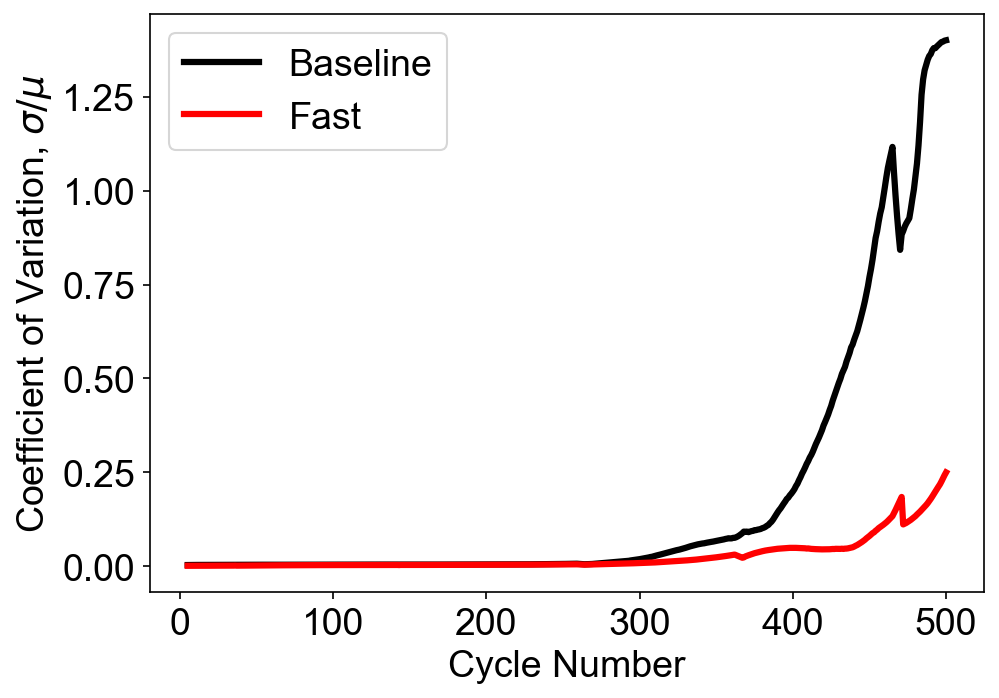

In [19]:
cellid_list = np.arange(1, 41)

num_base_cells = 20
num_fast_cells = 20

cyc_number_interp = np.arange(1, 501, 1)

cap_mat_fast = np.empty((len(cyc_number_interp), num_fast_cells))
cap_mat_fast[:, :] = np.NaN
idx_fast = 0

cap_mat_base = np.empty((len(cyc_number_interp), num_base_cells))
cap_mat_base[:, :] = np.NaN
idx_base = 0

for idx_cell, cellid in enumerate(cellid_list):
    
    cell = FormationCell(cellid)
    
    if cell.is_room_temp() or cell.cellid == 9:
        continue
        
    df = cell.get_aging_data_cycles()
    
    idx = np.where((df['Total Charge Time (s)'] > 8500) |
                   (df['Total Charge Time (s)'] < 100))[0]
    df = df.copy()
    df['Discharge Capacity (Ah)'][idx] = np.nan
    
    # Remove some things from the back
    cyc = df['Cycle Number']
    cap = df['Discharge Capacity (Ah)']
    
    cyc = cyc[~np.isnan(cap)]
    cap = cap[~np.isnan(cap)]
    
    cap_interp = np.interp(cyc_number_interp, cyc, cap, left=np.NaN, right=np.NaN)
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
        linestyle = ':' 
        cap_mat_base[:, idx_base] = cap_interp
        idx_base += 1
    else:
        color = COLOR_FAST_HT
        linestyle = ':'
        cap_mat_fast[:, idx_fast] = cap_interp
        idx_fast += 1
    
    plt.plot(cyc_number_interp, cap_interp, color=color, linestyle=linestyle)
    
cap_mean_base = np.nanmean(cap_mat_base, axis=1)
cap_mean_fast = np.nanmean(cap_mat_fast, axis=1)

cap_std_base = np.nanstd(cap_mat_base, axis=1)
cap_std_fast = np.nanstd(cap_mat_fast, axis=1)

plt.plot(cyc_number_interp, cap_mean_base, linewidth=3, color=COLOR_BASE, label='Baseline')
plt.plot(cyc_number_interp, cap_mean_fast, linewidth=3, color=COLOR_FAST_HT, label='Fast')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.legend()

plt.figure()

plt.plot(cyc_number_interp, cap_std_base/cap_mean_base, linewidth=3, color=COLOR_BASE, label='Baseline')
plt.plot(cyc_number_interp, cap_std_fast/cap_mean_fast, linewidth=3, color=COLOR_FAST_HT, label='Fast')  
plt.xlabel('Cycle Number')
plt.ylabel('Coefficient of Variation, $\sigma / \mu$')
plt.legend()

In [20]:
import scipy
print(scipy.version.version)

1.7.0


(0.8, 2.4)

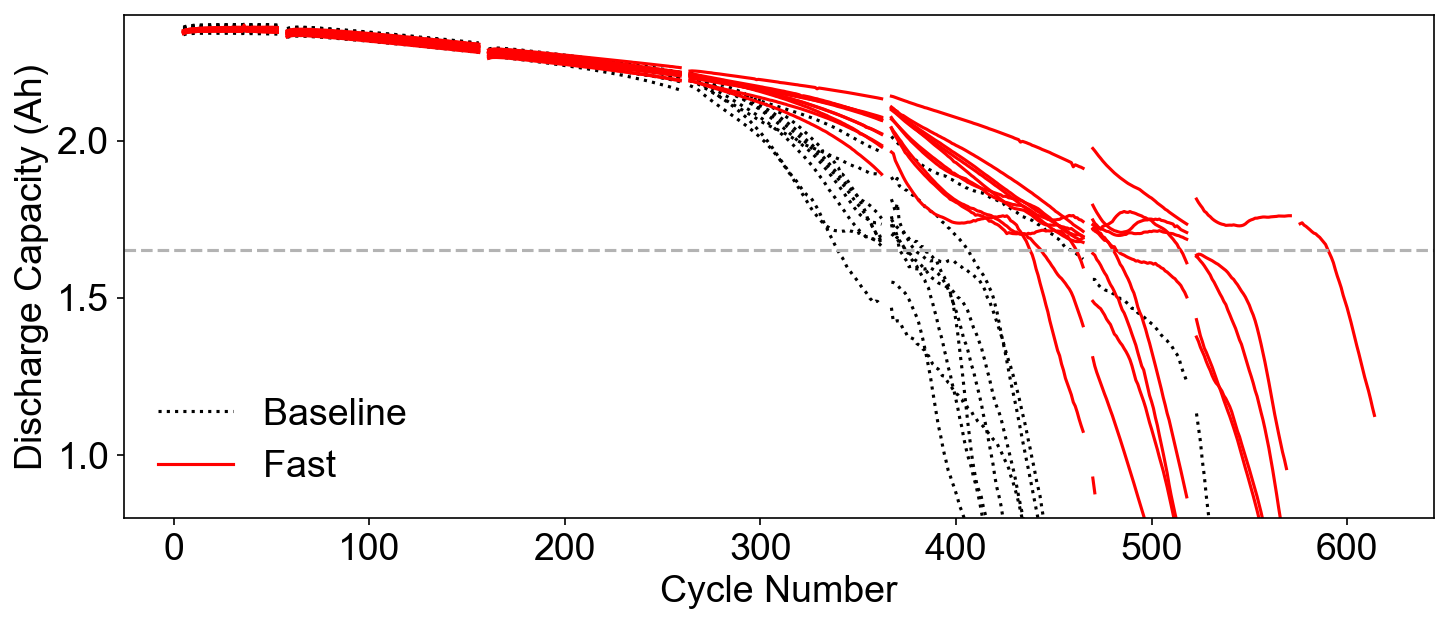

In [21]:
cellid_list = np.arange(1, 41)

plt.figure(figsize=(10, 4.5))

for cellid in cellid_list:
    cell = FormationCell(cellid)
    
    if cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
        linestyle = LINESTYLE_BASE
    else:
        color = COLOR_FAST_HT
        linestyle = LINESTYLE_FAST
        
    df = cell.get_aging_data_cycles()
    
    idx = np.where((df['Total Charge Time (s)'] > 8500) |
                   (df['Total Charge Time (s)'] < 100))[0]
    df = df.copy()
    df['Discharge Capacity (Ah)'][idx] = np.nan
    
    cyc = df['Cycle Number']
    cap = df['Discharge Capacity (Ah)']
    
    plt.plot(cyc, cap, 
             color=color, linestyle=linestyle)
    
plt.plot(np.nan, np.nan, label='Baseline ',
        color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(np.nan, np.nan, label='Fast ',
        color=COLOR_FAST_HT, linestyle=LINESTYLE_FAST)
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH, 
        color=COLOR_REF, linestyle='--')
plt.legend(loc=3, frameon=False)
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.ylim(CAPACITY_LIMITS_AH)

(0.8, 2.4)

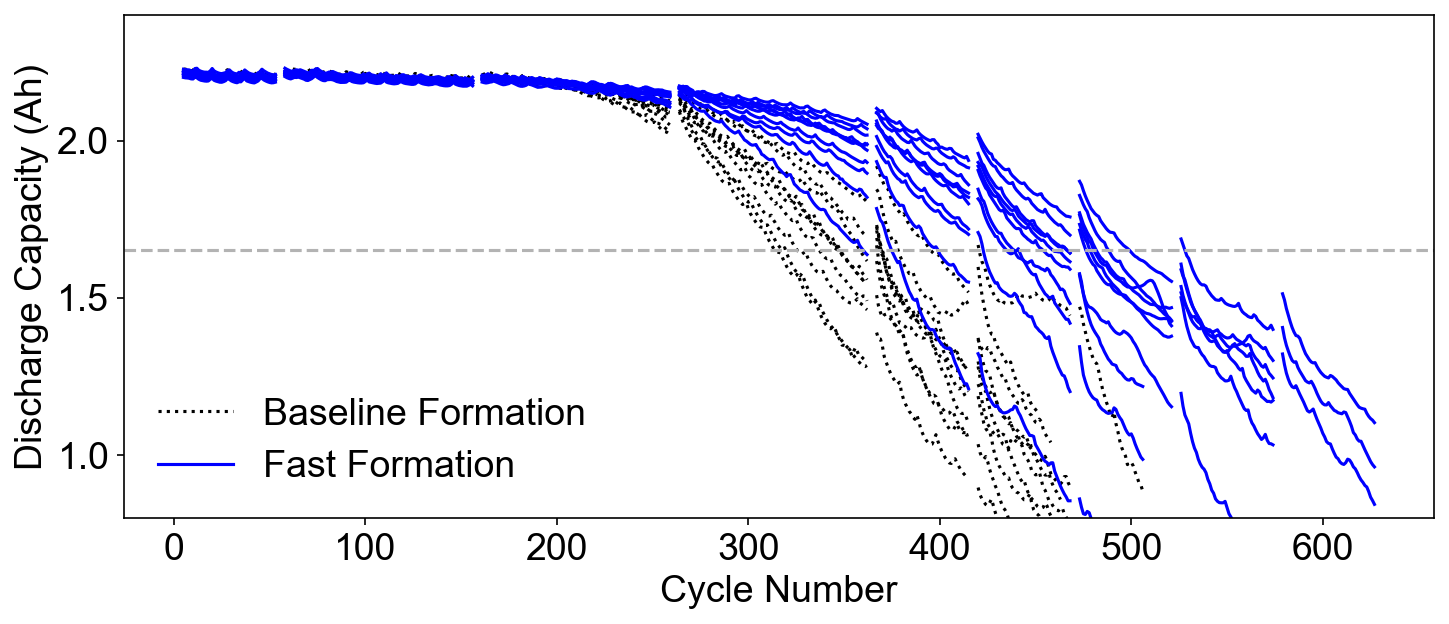

In [22]:
plt.figure(figsize=(10, 4.5))

for cellid in cellid_list:
    cell = FormationCell(cellid)
    
    if not cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
        linestyle = LINESTYLE_BASE
    else:
        color = COLOR_FAST_RT
        linestyle = LINESTYLE_FAST
        
    df = cell.get_aging_data_cycles()
    
    idx = np.where((df['Total Charge Time (s)'] > 8500) |
                   (df['Total Charge Time (s)'] < 100))[0]
    df['Discharge Capacity (Ah)'][idx] = np.nan
    
    cyc = df['Cycle Number']
    cap = df['Discharge Capacity (Ah)']
    
    plt.plot(cyc, cap, 
             color=color, linestyle=linestyle)

plt.plot(np.nan, np.nan, label='Baseline Formation',
        color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(np.nan, np.nan, label='Fast Formation',
        color=COLOR_FAST_RT, linestyle=LINESTYLE_FAST)
plt.legend(loc=3, frameon=False)
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH, 
            color=COLOR_REF, linestyle='--')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.ylim(CAPACITY_LIMITS_AH)

In [23]:
variable_name = 'cycles_to_70_pct'

df = pd.read_csv('output/correlation_data.csv')
group1 = df[(df['is_baseline_formation'] == False) & (df['is_room_temp_aging'] == True)][variable_name]
group2 = df[(df['is_baseline_formation'] == True) & (df['is_room_temp_aging'] == True)][variable_name]

# group1 = df[(df['is_baseline_formation'] == False)][variable_name]
# group2 = df[(df['is_baseline_formation'] == True)][variable_name]


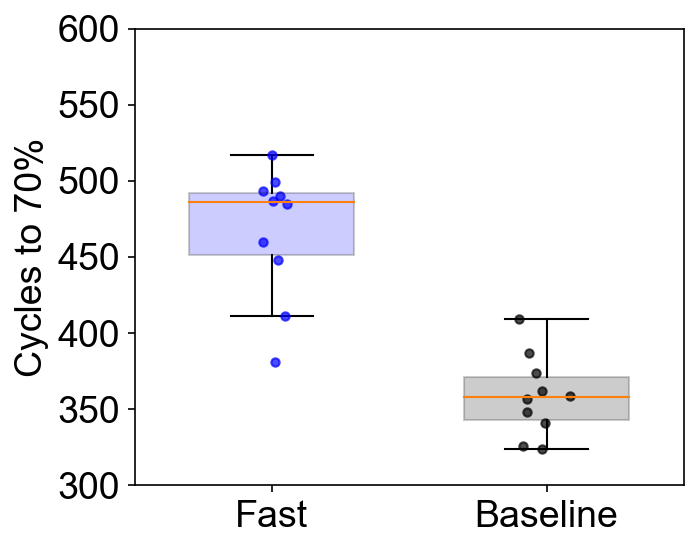

In [24]:
all_data = [group1, group2]
labels = ['Fast', 'Baseline']

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

# rectangular box plot
bplot = ax1.boxplot(all_data,
                    vert=True,  # vertical box alignment
                    patch_artist=True,  # fill with color
                    labels=labels,
                    showfliers=False,
                    widths=0.6)  # will be used to label x-ticks

x = np.random.normal(1, 0.06, size=len(all_data[0]))
plt.plot(x, all_data[0], marker='o', 
         markersize=4, linestyle='', color=COLOR_FAST_RT, alpha=0.7)

x = np.random.normal(2, 0.08, size=len(all_data[1]))
plt.plot(x, all_data[1], marker='o', 
         markersize=4, linestyle='', color=COLOR_BASE, alpha=0.7)

# fill with colors
colors = [COLOR_FAST_RT, COLOR_BASE]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.2)
  
# adding horizontal grid lines
for ax in [ax1]:
    ax.yaxis.grid(False)
    ax.set_ylabel('Cycles to 70%')
    ax.set_ylim((300, 600))

plt.show()


### Resistance vs SOC Maps

Working on cell 1...
Working on cell 2...
Working on cell 3...
Working on cell 4...
Working on cell 5...
Working on cell 6...
Working on cell 7...
Working on cell 8...
Working on cell 10...
Working on cell 11...
Working on cell 12...
Working on cell 13...
Working on cell 14...
Working on cell 15...
Working on cell 16...
Working on cell 17...
Working on cell 18...
Working on cell 19...
Working on cell 20...
Working on cell 21...
Working on cell 22...
Working on cell 23...
Working on cell 24...
Working on cell 25...
Working on cell 26...
Working on cell 27...
Working on cell 28...
Working on cell 29...
Working on cell 30...
Working on cell 31...
Working on cell 32...
Working on cell 33...
Working on cell 34...
Working on cell 35...
Working on cell 36...
Working on cell 37...
Working on cell 38...
Working on cell 39...
Working on cell 40...


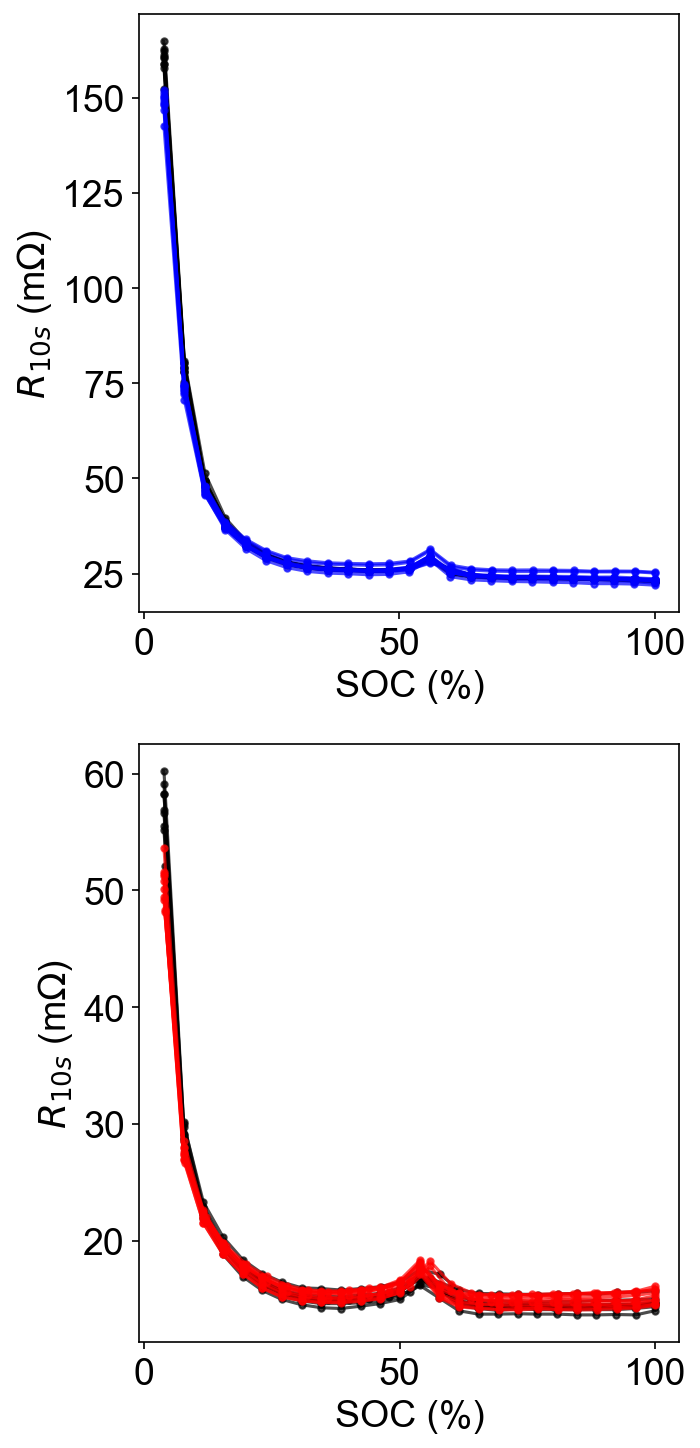

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(5, 10))

for cellid in cellid_list:
    
    cell = FormationCell(cellid)
    
    if cell.cellid == 9:
        continue
        
#     if cellid != CELL_BASE and cellid != CELL_FAST and cellid != 26 and cellid != 15:
#         continue
        
        
    print(f"Working on cell {cellid}...")
        
    ax = axs[0] if cell.is_room_temp() else axs[1]
    
    hppc_dict = cell.process_diagnostic_hppc_data()
        
    cap = hppc_dict[0]['data']['capacity']
    dcr = hppc_dict[0]['data']['resistance_10s_ohm']*1000
    
    soc = cap/np.max(cap)*100
        
    color = (0, 0, 1) if cell.is_room_temp() else (1, 0, 0)
    color = (0, 0, 0) if cell.is_baseline_formation() else color
    
    ax.plot(soc, dcr, color=color, marker='o', markersize=3, alpha=0.70)
    
#     ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 50, 100])
#     ax.set_xlim((3, 10))
    
[ax.set(ylabel='$R_{10s}$ (m$\Omega$)') for ax in axs]
[ax.set(xlabel='SOC (%)') for ax in axs]
[ax.grid(False) for ax in axs]

plt.show()

### Evolution of eSOH parameters over cycle number

Plot the evolution of x_0, x_100, y_0, y_100 over time

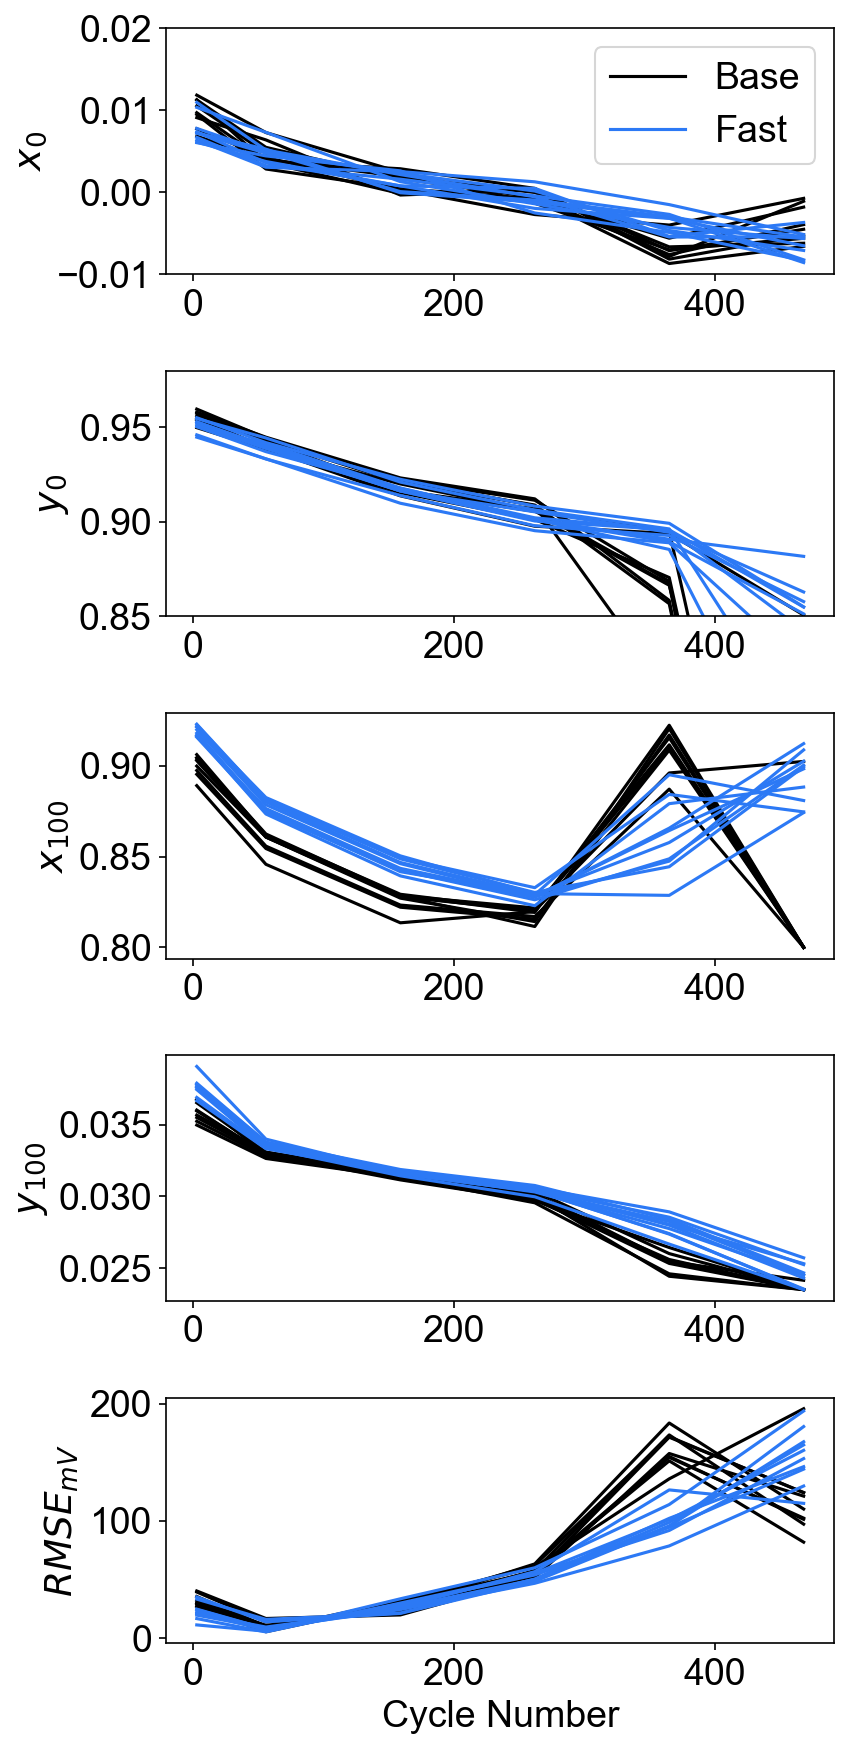

In [26]:
plt.figure(figsize=(6, 12))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

for cellid in cellid_list:
    
    cell = cell_dict[cellid]
    
    if cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
    else:
        color = COLOR_FAST
        
    esoh_data_list = cell_dict[cellid].get_esoh_fitting_data()

    cyc_number_list = [x['cycle_index'] for x in esoh_data_list]
    x_0_list = [x['x0'] for x in esoh_data_list]
    y_0_list = [x['y0'] for x in esoh_data_list]
    x_100_list = [x['x100'] for x in esoh_data_list]
    y_100_list = [x['y100'] for x in esoh_data_list]
    rmse_list = [x['RMSE_mV'] for x in esoh_data_list]
    
    ax1.plot(cyc_number_list, x_0_list, color=color)
    ax1.set_ylabel('$x_0$')
    ax1.set_ylim((-0.01, 0.02))

    ax2.plot(cyc_number_list, y_0_list, color=color)
    ax2.set_ylabel('$y_0$')
    ax2.set_ylim((0.85, 0.98))

    ax3.plot(cyc_number_list, x_100_list, color=color)
    ax3.set_ylabel('$x_{100}$')

    ax4.plot(cyc_number_list, y_100_list, color=color)
    ax4.set_ylabel('$y_{100}$')

    ax5.plot(cyc_number_list, rmse_list, color=color)
    ax5.set_ylabel('$RMSE_{mV}$')
    ax5.set_xlabel('Cycle Number')

ax1.plot(np.nan, np.nan, color=COLOR_BASE, label='Base')
ax1.plot(np.nan, np.nan, color=COLOR_FAST, label='Fast')

ax1.legend()
    

Prepare the two datasets for comparison

Compare the same cell, two aging conditions

In [27]:
esoh_data_1 = cell_dict[CELL_FAST].get_esoh_fitting_data()[0]
esoh_data_2 = cell_dict[CELL_FAST].get_esoh_fitting_data()[3]

print(f"Cycle {esoh_data_1['cycle_index']} to {esoh_data_2['cycle_index']}")
print(f"y0:   {esoh_data_1['y0']:.3f} --> {esoh_data_2['y0']:.3f}")
print(f"x0:   {esoh_data_1['x0']:.3f} --> {esoh_data_2['x0']:.3f}")
print(f"y100: {esoh_data_1['y100']:.3f} --> {esoh_data_2['y100']:.3f}")
print(f"x100: {esoh_data_1['x100']:.3f} --> {esoh_data_2['x100']:.3f}")
print(f"---")
print(f"LAM_PE = {100 - 100 * esoh_data_2['Cp'] / esoh_data_1['Cp']:.1f}%")
print(f"LAM_NE = {100 - 100 * esoh_data_2['Cn'] / esoh_data_1['Cn']:.1f}%")
print(f"LLI = {100 * (esoh_data_1['n_li'] - esoh_data_2['n_li']) / esoh_data_1['n_li'] :.1f}%")

Cycle 3.0 to 262.0
y0:   0.950 --> 0.902
x0:   0.007 --> -0.001
y100: 0.038 --> 0.031
x100: 0.922 --> 0.829
---
LAM_PE = 5.8%
LAM_NE = 0.9%
LLI = 11.3%


Here is another dataset for comparison

Compare a baseline vs fast formation cell, both fresh

In [28]:
esoh_data_1 = cell_dict[CELL_BASE].get_esoh_fitting_data()[0]
esoh_data_2 = cell_dict[CELL_FAST].get_esoh_fitting_data()[0]

print(f"       Base --> Fast")
print(f"y0:   {esoh_data_1['y0']:.3f} --> {esoh_data_2['y0']:.3f}")
print(f"x0:   {esoh_data_1['x0']:.3f} --> {esoh_data_2['x0']:.3f}")
print(f"y100: {esoh_data_1['y100']:.3f} --> {esoh_data_2['y100']:.3f}")
print(f"x100: {esoh_data_1['x100']:.3f} --> {esoh_data_2['x100']:.3f}")
print(f"---")
print(f"LAM_PE = {100 - 100 * esoh_data_2['Cp'] / esoh_data_1['Cp']:.1f}%")
print(f"LAM_NE = {100 - 100 * esoh_data_2['Cn'] / esoh_data_1['Cn']:.1f}%")
print(f"LLI = {100 * (esoh_data_1['n_li'] - esoh_data_2['n_li']) / esoh_data_1['n_li'] :.1f}%")

       Base --> Fast
y0:   0.954 --> 0.950
x0:   0.009 --> 0.007
y100: 0.037 --> 0.038
x100: 0.905 --> 0.922
---
LAM_PE = 0.2%
LAM_NE = 2.8%
LLI = 0.8%


### Available keys

In [29]:
xlim_array = [(-0.3, 3), 
              (-0.3, 0.3),
              (2.0, 2.6)]

neg_ylim_array = [(-0.05, 1.05),
                  (-0.05, 1.05),
                  (0.08, 0.095)]

pos_ylim_array = [(2.4, 4.55), 
                  (2.95, 3.75),
                  (4.10, 4.39)]

Text(0, 0.5, 'dV/dQ (V/Ah)')

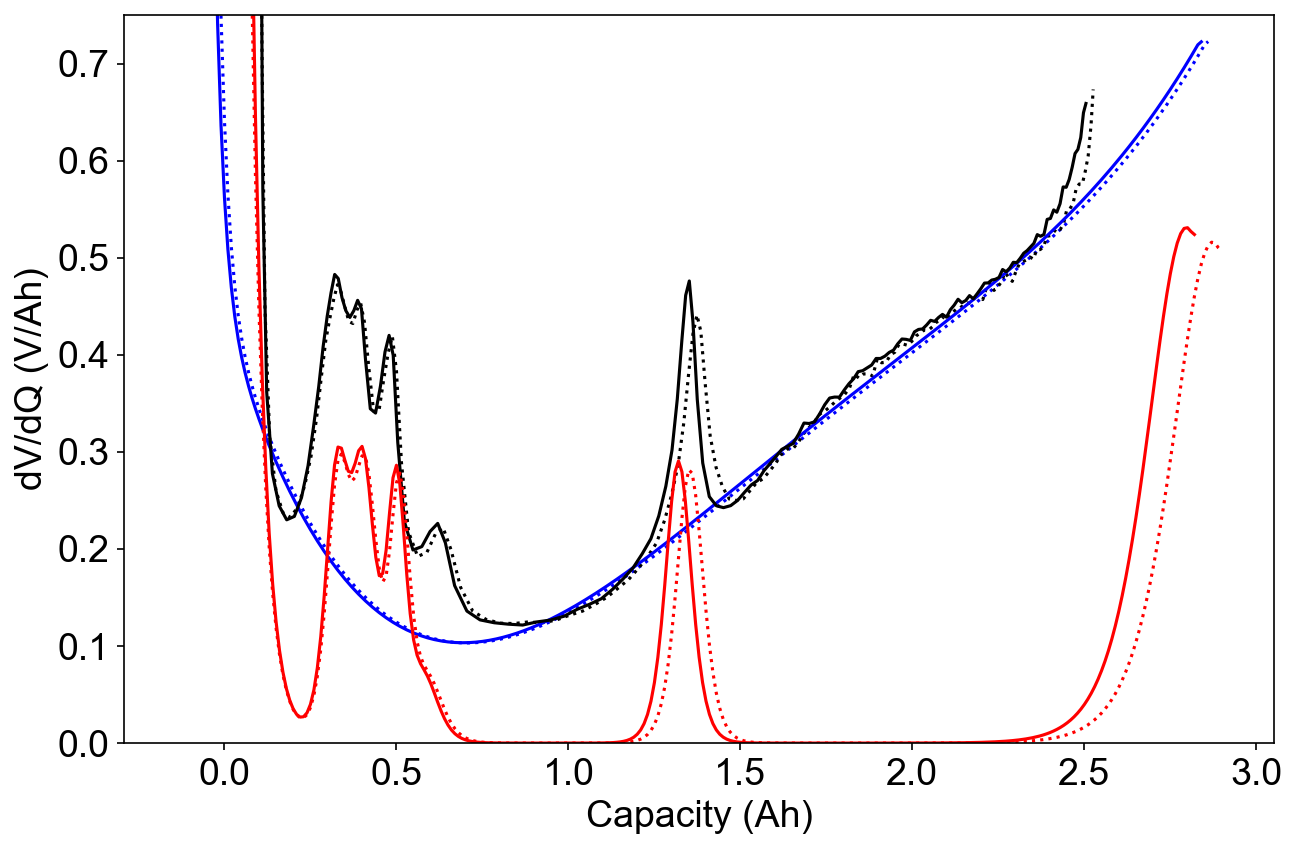

In [30]:
# dV/dQ
fig, ax = plt.subplots(figsize=(9,6))
    
plt.plot(esoh_data_1['pos']['Q'], esoh_data_1['pos']['dVdQ'], color=COLOR_POS, linestyle=':')
plt.plot(esoh_data_1['orig']['Q'], esoh_data_1['orig']['dVdQ'], color=COLOR_FULL_CELL, linestyle=':')
plt.plot(esoh_data_2['pos']['Q'], esoh_data_2['pos']['dVdQ'], color=COLOR_POS)
plt.plot(esoh_data_2['orig']['Q'], esoh_data_2['orig']['dVdQ'], color=COLOR_FULL_CELL)
plt.plot(esoh_data_1['neg']['Q'], esoh_data_1['neg']['dVdQ'], color=COLOR_NEG, linestyle=':')
plt.plot(esoh_data_2['neg']['Q'], esoh_data_2['neg']['dVdQ'], color=COLOR_NEG)

plt.ylim((0, 0.75))
plt.xlabel('Capacity (Ah)')
plt.ylabel('dV/dQ (V/Ah)')

In [31]:
esoh_data_1 = cell_dict[CELL_FAST].get_esoh_fitting_data()[0]
esoh_data_2 = cell_dict[CELL_FAST].get_esoh_fitting_data()[2]
esoh_data_3 = cell_dict[CELL_BASE].get_esoh_fitting_data()[0]
esoh_data_4 = cell_dict[CELL_BASE].get_esoh_fitting_data()[3]

print(f"       Base --> Fast  --> Fast (aged)")
print(f"y0:   {esoh_data_3['y0']:.3f} --> {esoh_data_1['y0']:.3f} --> {esoh_data_2['y0']:.3f}")
print(f"x0:   {esoh_data_3['x0']:.3f} --> {esoh_data_1['x0']:.3f} --> {esoh_data_2['x0']:.3f}")
print(f"y100: {esoh_data_3['y100']:.3f} --> {esoh_data_1['y100']:.3f} --> {esoh_data_2['y100']:.3f}")
print(f"x100: {esoh_data_3['x100']:.3f} --> {esoh_data_1['x100']:.3f} --> {esoh_data_2['x100']:.3f}")
print(f"---")
print(f"Fast --> Fast (aged)")
print(f"LAM_PE = {100 - 100 * esoh_data_2['Cp'] / esoh_data_1['Cp']:.1f}%")
print(f"LAM_NE = {100 - 100 * esoh_data_2['Cn'] / esoh_data_1['Cn']:.1f}%")
print(f"LLI = {100 * (esoh_data_1['n_li'] - esoh_data_2['n_li']) / esoh_data_1['n_li'] :.1f}%")
print(f"---")
print(f"Base --> Fast")
print(f"LAM_PE = {100 - 100 * esoh_data_1['Cp'] / esoh_data_3['Cp']:.1f}%")
print(f"LAM_NE = {100 - 100 * esoh_data_1['Cn'] / esoh_data_3['Cn']:.1f}%")
print(f"LLI = {100 * (esoh_data_3['n_li'] - esoh_data_1['n_li']) / esoh_data_3['n_li'] :.1f}%")
print(f"Base --> Base (aged)")
print(f"LAM_PE = {100 - 100 * esoh_data_4['Cp'] / esoh_data_3['Cp']:.1f}%")
print(f"LAM_NE = {100 - 100 * esoh_data_4['Cn'] / esoh_data_3['Cn']:.1f}%")
print(f"LLI = {100 * (esoh_data_3['n_li'] - esoh_data_4['n_li']) / esoh_data_3['n_li'] :.1f}%")


       Base --> Fast  --> Fast (aged)
y0:   0.954 --> 0.950 --> 0.918
x0:   0.009 --> 0.007 --> -0.000
y100: 0.037 --> 0.038 --> 0.032
x100: 0.905 --> 0.922 --> 0.847
---
Fast --> Fast (aged)
LAM_PE = 4.4%
LAM_NE = -0.2%
LLI = 8.4%
---
Base --> Fast
LAM_PE = 0.2%
LAM_NE = 2.8%
LLI = 0.8%
Base --> Base (aged)
LAM_PE = 6.4%
LAM_NE = 2.4%
LLI = 12.0%


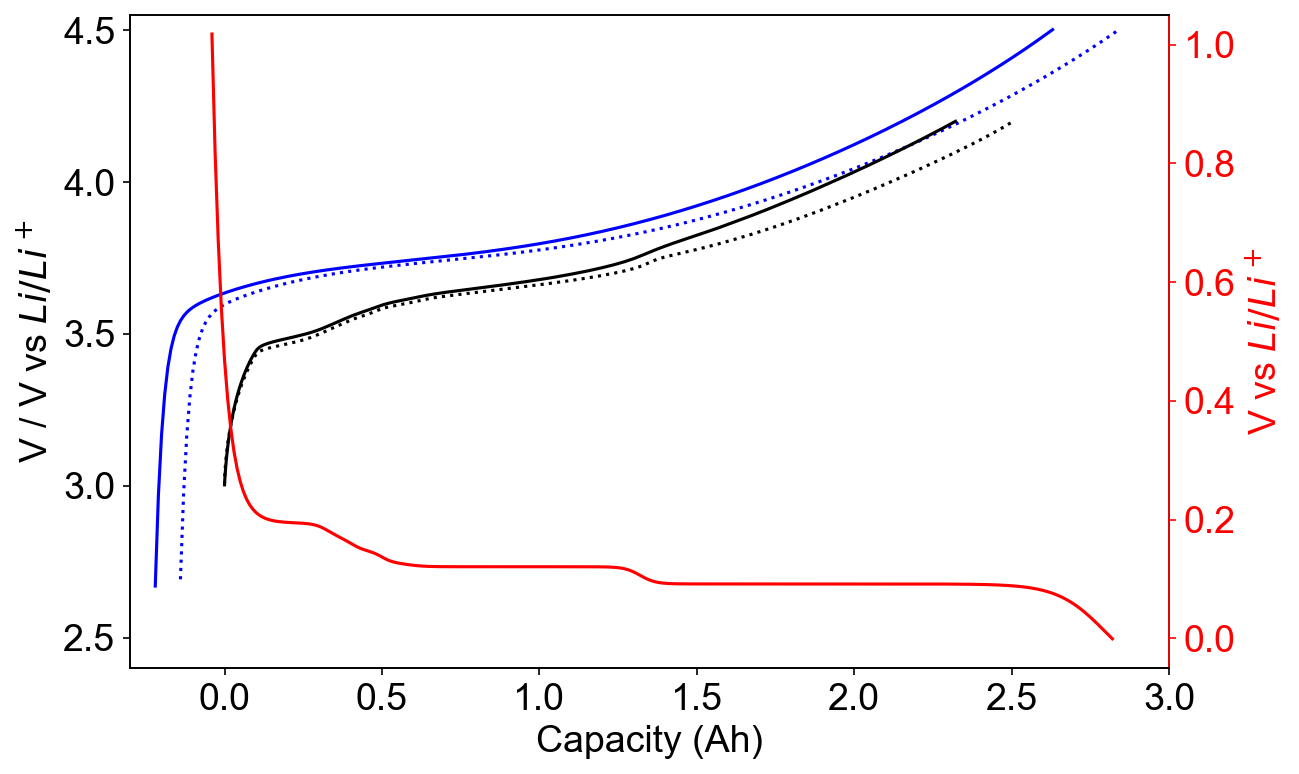

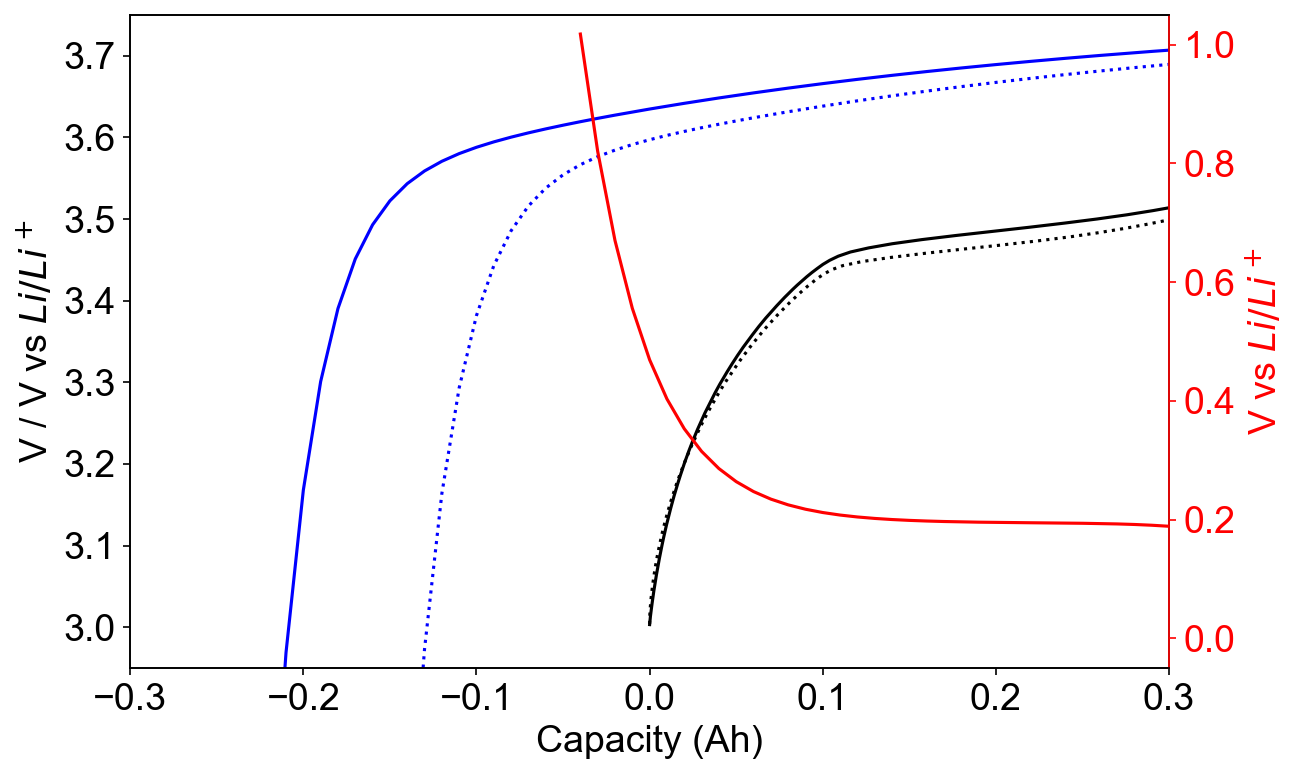

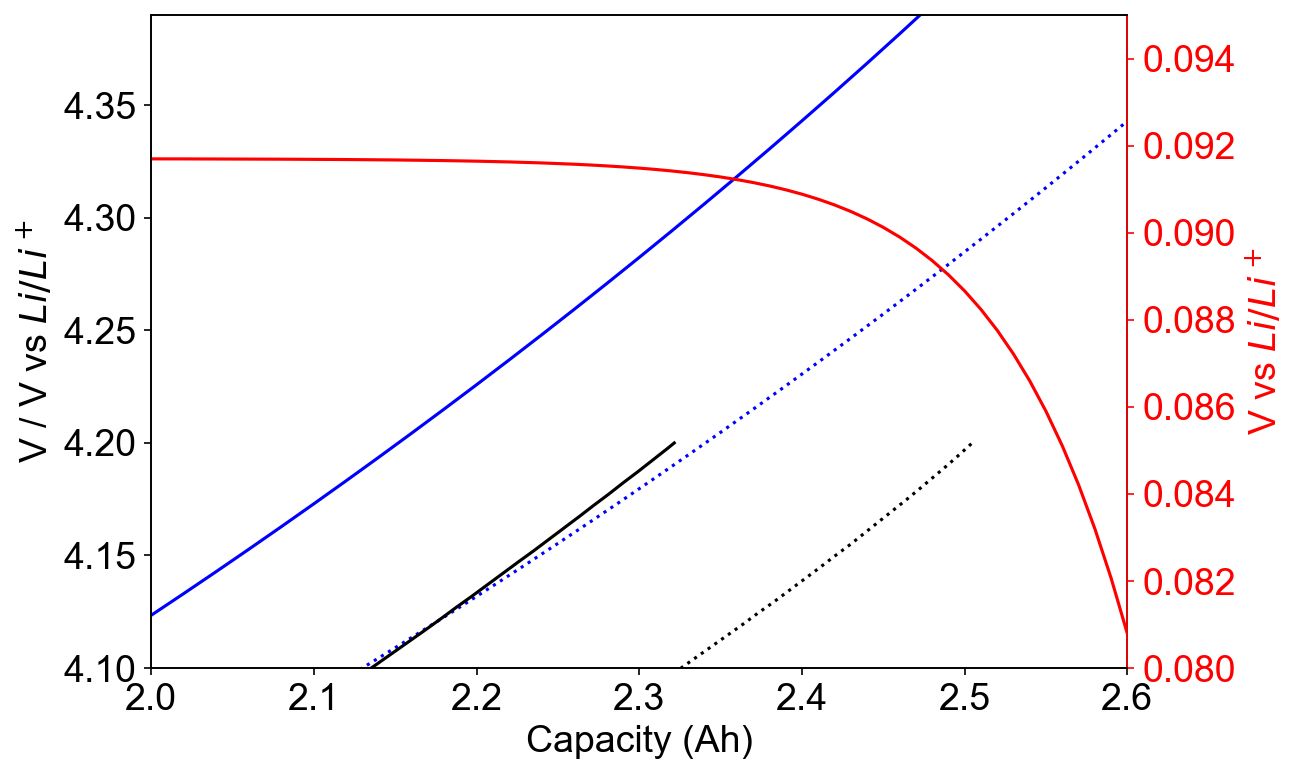

In [32]:
fig_arr, ax_arr, ax2_arr = [], [], []

for (xlim, neg_ylim, pos_ylim) in zip(xlim_array, neg_ylim_array, pos_ylim_array):

    fig, ax = plt.subplots(figsize=(9,5.5))
    ax2 = ax.twinx()
    
    fig_arr.append(fig)
    ax_arr.append(ax)
    ax2_arr.append(ax2)
    
    ax.plot(esoh_data_1['pos']['Q'], esoh_data_1['pos']['V'], color=COLOR_POS, linestyle=':')
    ax.plot(esoh_data_1['orig']['Q'], esoh_data_1['orig']['V'], color=COLOR_FULL_CELL, linestyle=':')
    ax2.plot(esoh_data_1['neg']['Q'], esoh_data_1['neg']['V'], color=COLOR_NEG, linestyle='-')
    
    ax.plot(esoh_data_2['pos']['Q'], esoh_data_2['pos']['V'], color=COLOR_POS)
    ax.plot(esoh_data_2['orig']['Q'], esoh_data_2['orig']['V'], color=COLOR_FULL_CELL)
#     ax2.plot(esoh_data_2['neg']['Q'], esoh_data_2['neg']['V'], color=COLOR_NEG)

#     ax.plot(esoh_data_3['pos']['Q'], esoh_data_3['pos']['V'], color=np.array([3, 211, 252])/255, linestyle=':')
#     ax.plot(esoh_data_3['orig']['Q'], esoh_data_3['orig']['V'], color=np.array([0.5, 0.5, 0.5]), linestyle=':')
#     ax2.plot(esoh_data_3['neg']['Q'], esoh_data_3['neg']['V'], color=np.array([252, 123, 3])/255, linestyle=':')
    
#     ax.plot(esoh_data_4['pos']['Q'], esoh_data_4['pos']['V'], color=np.array([3, 211, 252])/255, linestyle='-')
#     ax.plot(esoh_data_4['orig']['Q'], esoh_data_4['orig']['V'], color=np.array([0.5, 0.5, 0.5]), linestyle='-')
#     ax2.plot(esoh_data_4['neg']['Q'], esoh_data_4['neg']['V'], color=np.array([252, 123, 3])/255, linestyle='-')
    
    ax.set_xlabel('Capacity (Ah)')
    ax2.yaxis.label.set_color(COLOR_NEG)
    ax2.spines["right"].set_edgecolor(COLOR_NEG)
    ax2.tick_params(axis='y', colors=COLOR_NEG)

    ax.set_ylabel('V / V vs $Li/Li^+$')
    ax2.set_ylabel('V vs $Li/Li^+$')
    ax.set_xlim(xlim)
    ax2.set_ylim(neg_ylim)
    ax.set_ylim(pos_ylim)

# ax_arr[1].plot([0, 0], [0, 5], color=COLOR_REF, linestyle='--')
# 
# ax_arr[2].plot([esoh_data_1['orig']['Q'][-1], esoh_data_1['orig']['Q'][-1]], 
#                [0, 5], color=COLOR_REF, linestyle='--')
# ax_arr[2].plot([esoh_data_2['orig']['Q'][-1], esoh_data_2['orig']['Q'][-1]], 
#                [0, 5], color=COLOR_REF, linestyle='--')
# ax_arr[2].plot([esoh_data_3['orig']['Q'][-1], esoh_data_3['orig']['Q'][-1]], 
#                [0, 5], color=COLOR_REF, linestyle='--')
# ax_arr[2].plot([esoh_data_4['orig']['Q'][-1], esoh_data_4['orig']['Q'][-1]], 
#                [0, 5], color=COLOR_REF, linestyle='--')

Text(0, 0.5, 'dV/dQ (V/Ah)')

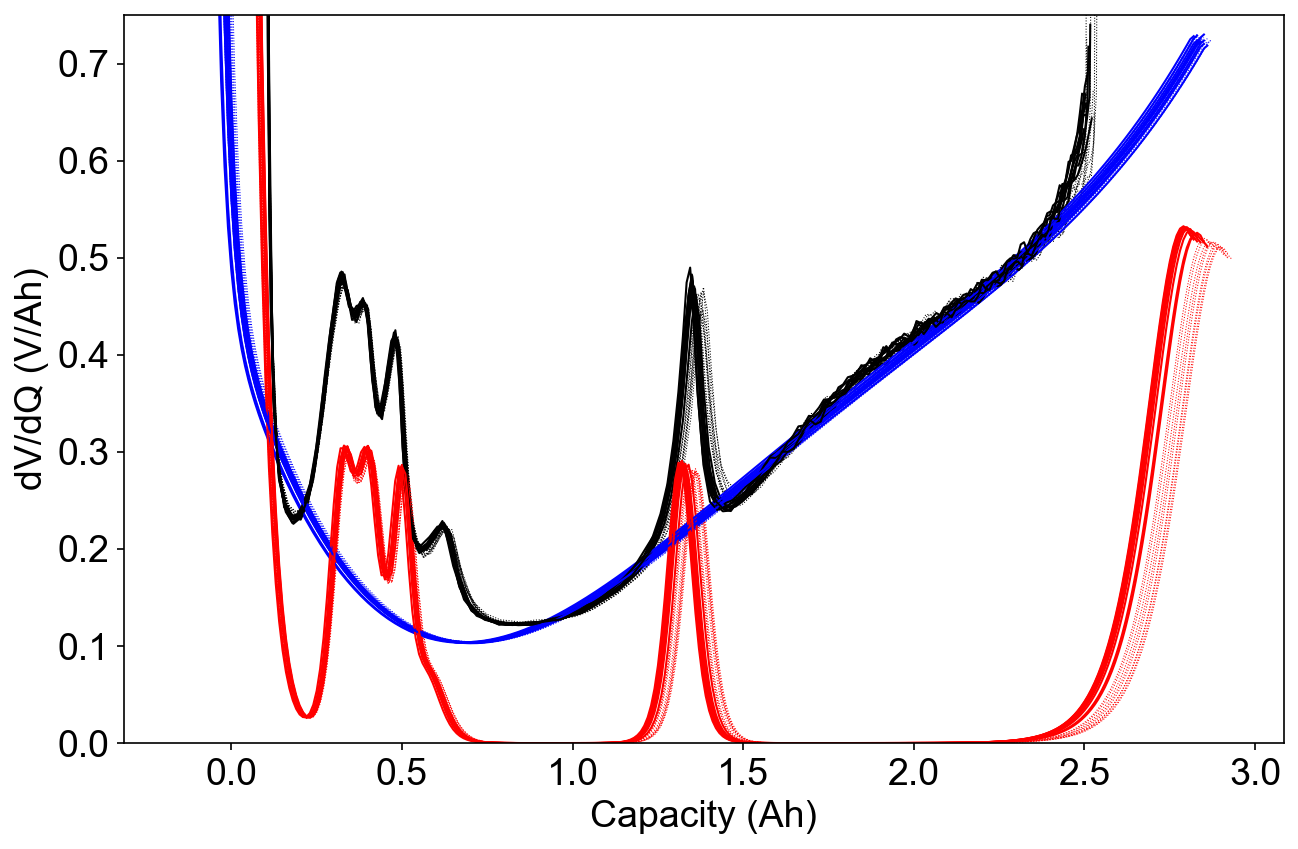

In [33]:
# dV/dQ
fig, ax = plt.subplots(figsize=(9,6))

for cellid in cellid_list:
    
    cell = cell_dict[cellid]
    
    if cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        linestyle = ':'
        linewidth = 0.5
    else:
        linestyle = '-'
        linewidth = 1
        
    esoh_data = cell.get_esoh_fitting_data()[0]
    assert esoh_data['cycle_index'] == 3
        
    plt.plot(esoh_data['pos']['Q'], esoh_data['pos']['dVdQ'], 
             color=COLOR_POS, linestyle=linestyle, linewidth=linewidth)
    plt.plot(esoh_data['orig']['Q'], esoh_data['orig']['dVdQ'], 
             color=COLOR_FULL_CELL, linestyle=linestyle, linewidth=linewidth)
    plt.plot(esoh_data['neg']['Q'], esoh_data['neg']['dVdQ'], 
             color=COLOR_NEG, linestyle=linestyle, linewidth=linewidth)

plt.ylim((0, 0.75))
plt.xlabel('Capacity (Ah)')
plt.ylabel('dV/dQ (V/Ah)')

In [34]:
data = cell.get_esoh_fitting_data()

In [35]:
[x['cycle_index'] for x in data]

[3.0, 56.0, 159.0, 262.0, 365.0, 468.0]

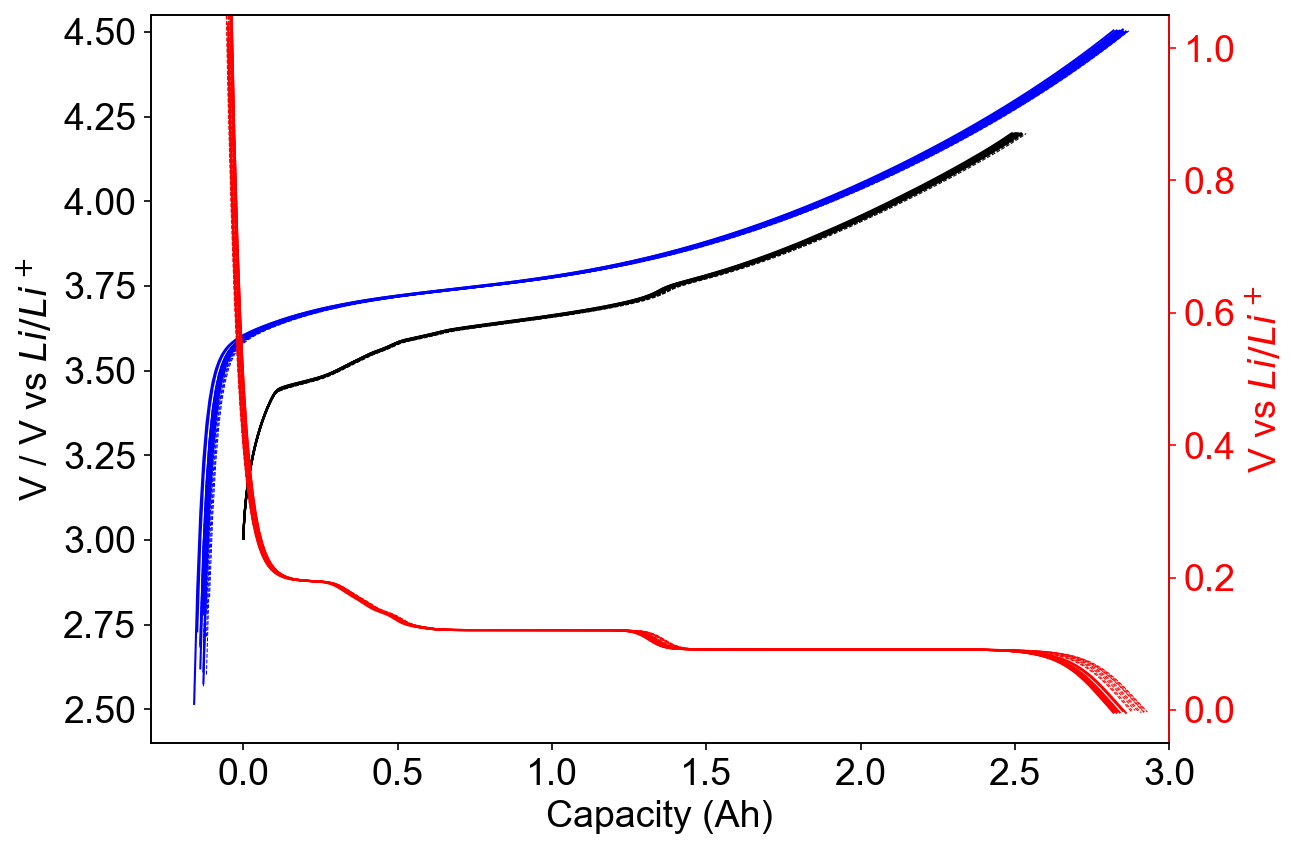

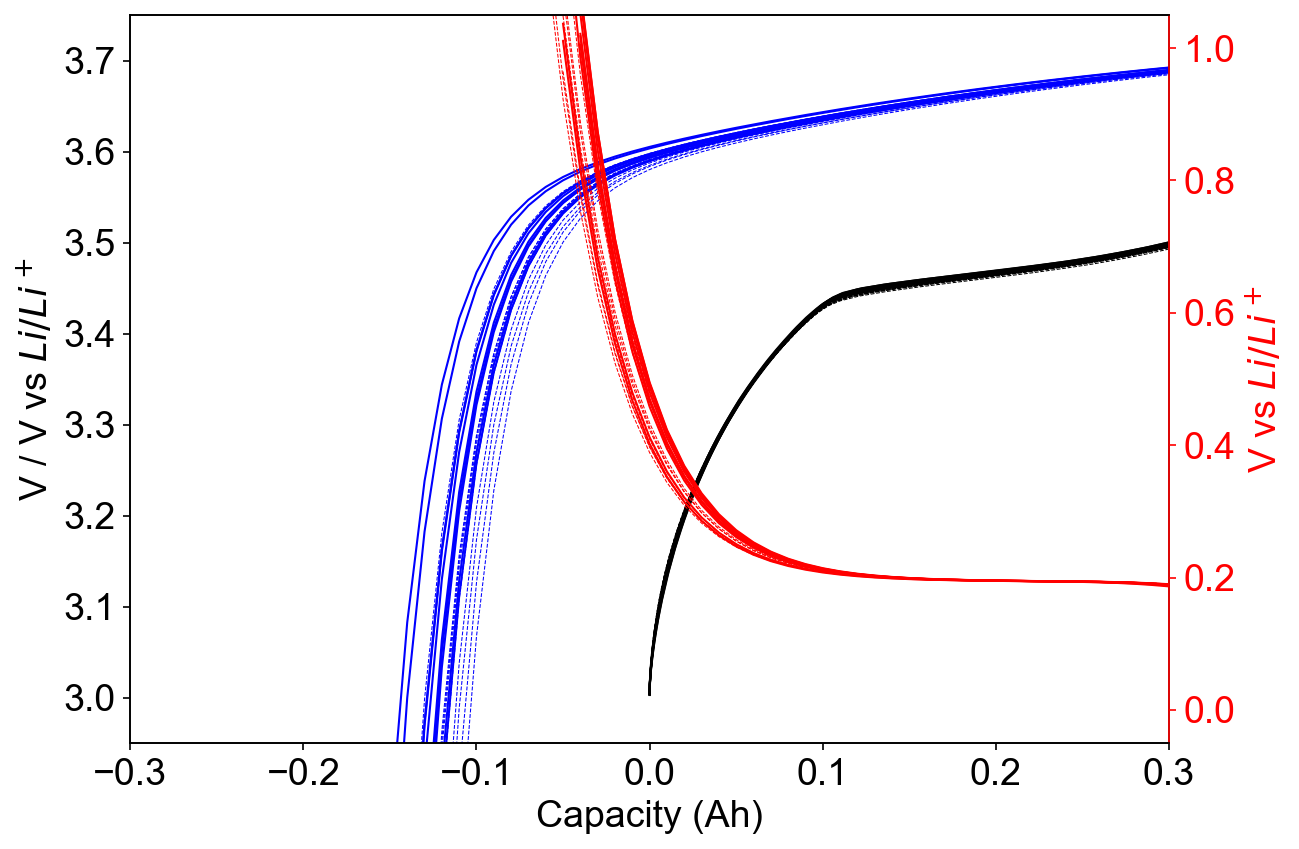

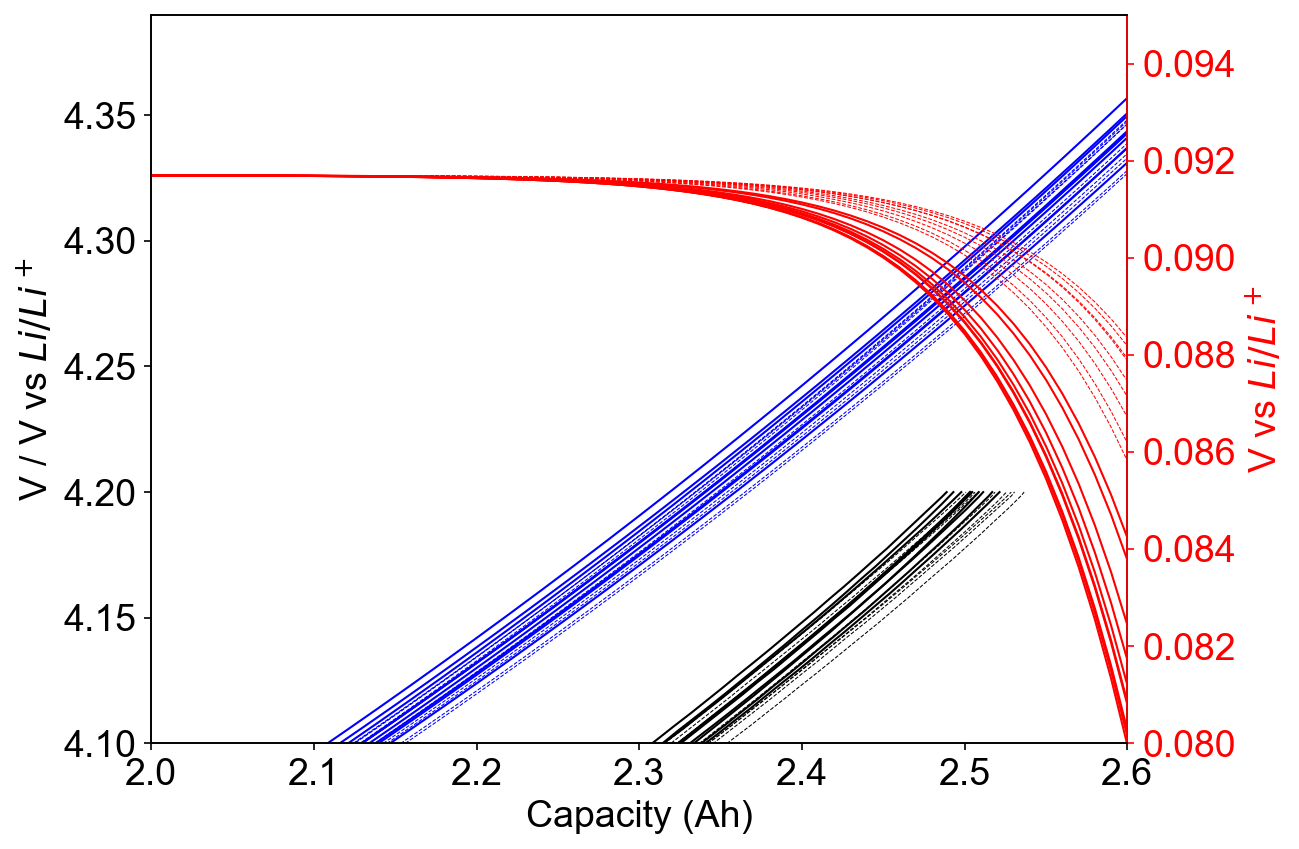

In [36]:
fig_arr, ax_arr, ax2_arr = [], [], []

for (xlim, neg_ylim, pos_ylim) in zip(xlim_array, neg_ylim_array, pos_ylim_array):

    fig, ax = plt.subplots(figsize=(9,6))
    ax2 = ax.twinx()
    
    fig_arr.append(fig)
    ax_arr.append(ax)
    ax2_arr.append(ax2)
    
    for cellid in cellid_list:
        
        cell = cell_dict[cellid]

        if cell.is_room_temp() or cell.cellid == 9:
            continue
            
        if cell.is_baseline_formation():
            linestyle = '--'
            linewidth = 0.5
        else:
            linestyle = '-'
            linewidth = 1

        esoh_data = cell.get_esoh_fitting_data()[0]
        assert esoh_data['cycle_index'] == 3        

        ax.plot(esoh_data['pos']['Q'], esoh_data['pos']['V'], 
                color=COLOR_POS, linestyle=linestyle, linewidth=linewidth)
        ax.plot(esoh_data['orig']['Q'], esoh_data['orig']['V'], 
                color=COLOR_FULL_CELL, linestyle=linestyle, linewidth=linewidth)
        ax2.plot(esoh_data['neg']['Q'], esoh_data['neg']['V'], 
                 color=COLOR_NEG, linestyle=linestyle, linewidth=linewidth)

        ax.set_xlabel('Capacity (Ah)')
        ax2.yaxis.label.set_color(COLOR_NEG)
        ax2.spines["right"].set_edgecolor(COLOR_NEG)
        ax2.tick_params(axis='y', colors=COLOR_NEG)

        ax.set_ylabel('V / V vs $Li/Li^+$')
        ax2.set_ylabel('V vs $Li/Li^+$')
        ax.set_xlim(xlim)
        ax2.set_ylim(neg_ylim)
        ax.set_ylim(pos_ylim)

Comparison of metrics

In [37]:
df = pd.DataFrame([esoh_data_1, esoh_data_2], index=['1', '2'])
df = df.drop(columns=['ful', 'pos', 'neg', 'orig', 'Xt'])
# df = df.transpose()
df

,np_ratio,Cp,Cn,y100,y0,x0,x100,n_li,Cn_excess,Cp_excess,Cf,RMSE_mV,Cn_pf,x100_pf,cycle_index
1,0.998022,2.739773,2.734355,0.037883,0.950368,0.007241,0.921533,0.09789,0.32,0.14,2.50,21.222650,2.856612,0.889973,3.0
2,1.045994,2.619009,2.739467,0.031870,0.917702,-0.000072,0.846808,0.08967,0.53,0.22,2.32,25.899812,2.797880,0.833661,159.0


Percentage changes:

In [38]:
df.pct_change(axis='rows')*100

,np_ratio,Cp,Cn,y100,y0,x0,x100,n_li,Cn_excess,Cp_excess,Cf,RMSE_mV,Cn_pf,x100_pf,cycle_index
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.806643,-4.407812,0.186963,-15.87224,-3.437201,-100.999138,-8.108813,-8.397637,65.625,57.142857,-7.2,22.038538,-2.056006,-6.327446,5200.0


# Plot the $\Delta Q$ metric

Processing cell 40...
Processing cell 1...
Processing cell 2...
Processing cell 3...
Processing cell 4...
Processing cell 5...
Processing cell 6...
Processing cell 7...
Processing cell 8...
Processing cell 9...
Processing cell 10...
Processing cell 11...
Processing cell 12...
Processing cell 13...
Processing cell 14...
Processing cell 15...
Processing cell 16...
Processing cell 17...
Processing cell 18...
Processing cell 19...
Processing cell 20...
Processing cell 21...
Processing cell 22...
Processing cell 23...
Processing cell 24...
Processing cell 25...
Processing cell 26...
Processing cell 27...
Processing cell 28...
Processing cell 29...
Processing cell 30...
Processing cell 31...
Processing cell 32...
Processing cell 33...
Processing cell 34...
Processing cell 35...
Processing cell 36...
Processing cell 37...
Processing cell 38...
Processing cell 39...


Text(0.5, 1.0, '45C')

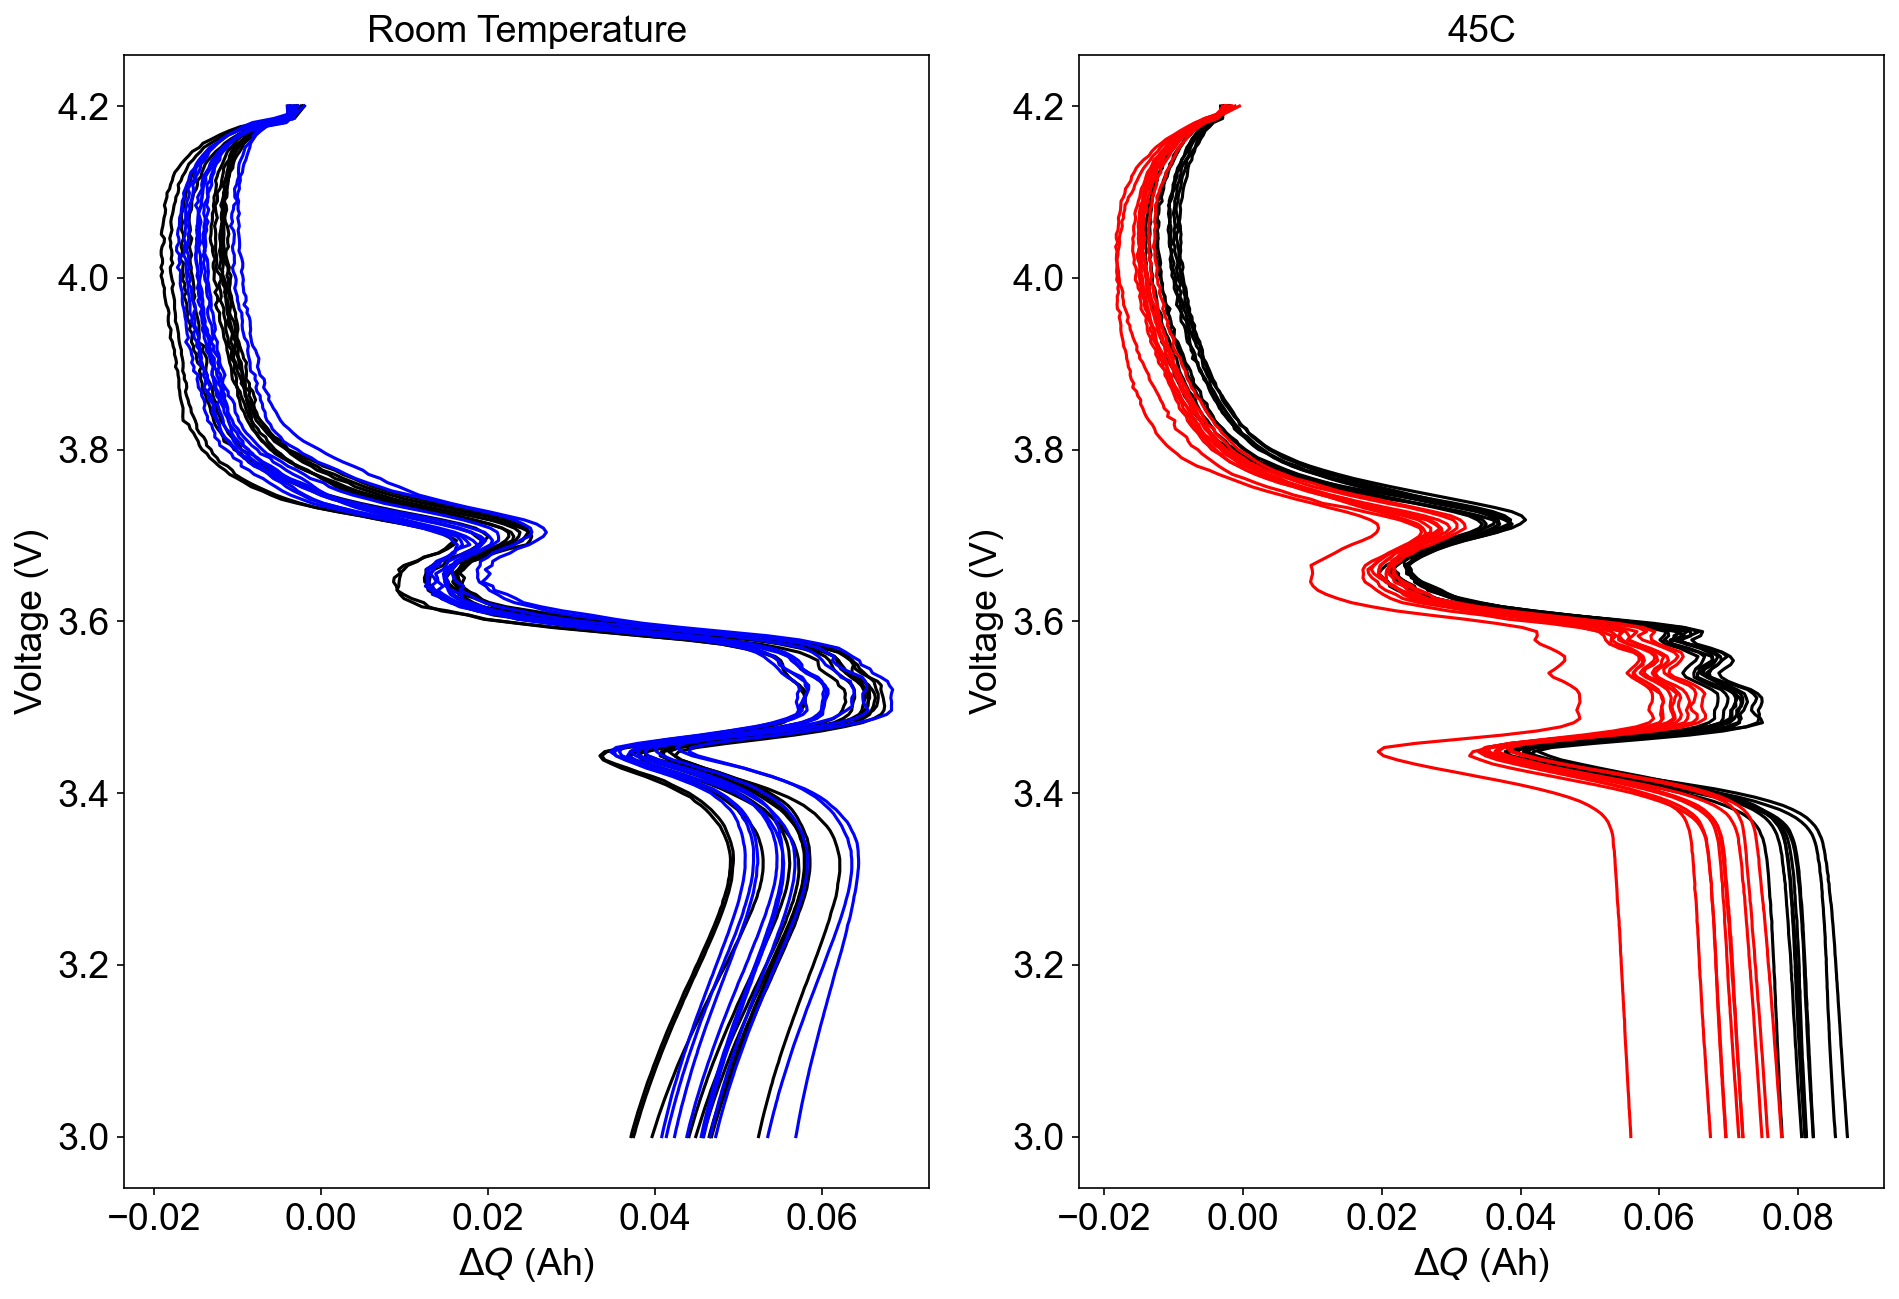

In [39]:
plt.figure(figsize=(13, 9))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for cellid in cellid_list:
    
    print(f'Processing cell {cell.cellid}...')
    
    cell = cell_dict[cellid]
    
    if cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
    else: 
        if cell.is_room_temp():
            color = COLOR_FAST_RT
        else: 
            color = COLOR_FAST_HT
            
    if cell.is_room_temp():
        ax = ax1
    else:
        ax = ax2
        
    res = cell.calculate_var_q_c20_discharge()
    
    ax.plot(res['var_q_c20_c56_c3_delta_q'], res['var_q_c20_c56_c3_voltage_v'], color=color)

ax1.set_ylabel('Voltage (V)')
ax1.set_xlabel('$\Delta Q$ (Ah)')
ax2.set_ylabel('Voltage (V)')
ax2.set_xlabel('$\Delta Q$ (Ah)')
ax1.set_title('Room Temperature')
ax2.set_title('45C')